<a href="https://colab.research.google.com/github/kai-lnin/f23/blob/main/NewsHeadlinesData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#confirm use of gpu

import torch

if torch.cuda.is_available():
  device = torch.device("cuda")
  print('There are %d GPU(s) available.' % torch.cuda.device_count())
  print('We will use the GPU: ', torch.cuda.get_device_name(0))

#if not
else:
  print('No GPU available, using the CPU')
  device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU:  Tesla T4


installing transformers

In [ ]:
!pip install transformers

loading dataset

In [ ]:
!pip install wget

  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=a511373861acb2ac5d247608838bca6a6f6464aeee772b1d1ed75e28d8133301
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget


In [ ]:
import wget
import os

print('Downloading dataset...')


from google.colab import files
uploaded = files.upload()

Saving Sarcasm_Headlines_Dataset_v2.json to Sarcasm_Headlines_Dataset_v2.json


In [ ]:
#paths file to colab
if not os.path.exists('./Sarcasm_Headlines_Dataset_v2.json'):
  wget.download(uploaded, './Sarcasm_Headlines_Dataset_v2.json')

# Create Dataframe

In [ ]:
import pandas as pd

dataframe = pd.read_json('Sarcasm_Headlines_Dataset_v2.json', lines=True)
#report number of headlines
print('Number of training headlines: {:,}\n'.format(dataframe.shape[0]))

dataframe.sample(10)

Number of training headlines: 28,619



,is_sarcastic,headline,article_link
3831,1,majority of americans thought we already had a...,https://www.theonion.com/majority-of-americans...
2209,0,obama administration takes deportation relief ...,https://www.huffingtonpost.com/entry/dapa-supr...
15825,0,$9 billion is a lot of money: how much could y...,https://www.huffingtonpost.com/entry/9-billion...
16519,0,this week in world war i november 29-december ...,https://www.huffingtonpost.com/entry/this-week...
27747,0,my 9/11 walk your talk pilgrimage,https://www.huffingtonpost.com/entry/my-911-wa...
10985,1,philip morris introduces new marlboro sinus pm...,https://www.theonion.com/philip-morris-introdu...
8596,1,endangered species list edited to fit poster,https://www.theonion.com/endangered-species-li...
1351,1,report finds letting stranger bum cigarette so...,https://www.theonion.com/report-finds-letting-...
18524,1,e. coli ready to treat itself to some beef aft...,https://local.theonion.com/e-coli-ready-to-tre...
19903,0,"guide your child's intellectual development, p...",https://www.huffingtonpost.com/entry/guide-you...


In [ ]:
#fives examples of not sarcastic
dataframe.loc[dataframe.is_sarcastic == 0].sample(5)[['headline','is_sarcastic']]

,headline,is_sarcastic
11512,amy poehler loses best lead actress in a comed...,0
21884,you're tackling your to-do list all wrong -- h...,0
20202,how to overcome the stress of long distance re...,0
25973,kylie jenner sports massive septum ring in her...,0
24878,middle (st)age never stop learning,0


# Tokenize First!

In [ ]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

#extract headline vs. is_sarcastic
headlines = dataframe.headline.values
sarcasm = dataframe.is_sarcastic.values
# alrerady numpy
print("headlines datatype: ", headlines.dtype)
print("sarcasm datatype: ", sarcasm.dtype)

headlines datatype:  object
sarcasm datatype:  int64


In [ ]:
from transformers import BertTokenizer

#load BERT tokenizer
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

apply to one headline to see output

In [ ]:
#Print origial headline
print(' Original: ', headlines[0])

#Print headlines split into tokens
print('Tokenized: ', tokenizer.tokenize(headlines[0]))

#Print headline mapped to token ids
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(headlines[0])))

 Original:  thirtysomething scientists unveil doomsday clock of hair loss
Tokenized:  ['thirty', '##some', '##thing', 'scientists', 'un', '##ve', '##il', 'doom', '##sd', '##ay', 'clock', 'of', 'hair', 'loss']
Token IDs:  [4228, 14045, 20744, 6529, 4895, 3726, 4014, 12677, 16150, 4710, 5119, 1997, 2606, 3279]


Have to Clean this data up.... use encode to parse and data prep

In [ ]:
max_len = 0

#for every headline
for text in headlines:
  #tokenize text and add '[CLS]' and '[SEP]' tokens.
  input_ids = tokenizer.encode(text, add_special_tokens=True)

  #update max headline length
  max_len = max(max_len, len(input_ids))

print('Max headline length: ', max_len)

Max headline length:  193


In [ ]:
#fr tokenize

input_ids = []
attention_masks = []

#for every headline
for text in headlines:
  encoding = tokenizer.encode_plus(
      text,
      add_special_tokens = True,
      max_length = 64,
      pad_to_max_length = True,
      return_attention_mask = True,
      return_tensors = 'pt',
  )

  #add headline to list
  input_ids.append(encoding['input_ids'])
  #also add attnetion mask / padding vs. non padding
  attention_masks.append(encoding['attention_mask'])

#convert arrays to tensors

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
sarcasm = torch.tensor(sarcasm)

#print sentence 0 as list of IDs

print('Original: ', headlines[0])
print('Token IDs: ', input_ids[0])


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  thirtysomething scientists unveil doomsday clock of hair loss
Token IDs:  tensor([  101,  4228, 14045, 20744,  6529,  4895,  3726,  4014, 12677, 16150,
         4710,  5119,  1997,  2606,  3279,   102,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


# Training Validation & Testing Split

In [ ]:
from torch.utils.data import random_split

dataset = TensorDataset(input_ids, attention_masks, sarcasm)

#create 80-10-10 train-val-test split

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size

#split data by random samples
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))
print('{:>5,} test samples'.format(test_size))

22,895 training samples
2,861 validation samples
2,863 test samples


iterator using torch dataloader class. save mem during training bc does not need to be loaded into mem

In [ ]:
from torch.utils.data import RandomSampler, SequentialSampler

#batch size for training, 16 or 32 for BERT
batch_size = 32

train_dataloader = DataLoader(
    train_dataset,
    sampler = RandomSampler(train_dataset),
    batch_size = batch_size
)

validation_dataloader = DataLoader(
    val_dataset,
    sampler = SequentialSampler(val_dataset),
    batch_size = batch_size
)

test_dataloader = DataLoader(
    test_dataset,
    sampler = SequentialSampler(test_dataset),
    batch_size = batch_size
)

# Training Classification Model / FINE TUNING BERT!

using bert for sequence classification. added single linear layer for classification using as headline classifier.

loading bert 'bert-base-uncased'

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

#load BERT
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",
    num_labels = 2, #binary classification
    output_attentions = False,
    output_hidden_states = False,
)

#run on gpu
model.cuda()

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

# optimizer and learning rate scheduler

batch size: 16, 32
learning rate: 5e-5, 3e-5, 2e-5
number of epochs: 2, 3, 4

In [ ]:
#define optimizer
optimizer = AdamW(model.parameters(),
                  lr = 2e-5,
                  eps = 1e-8
                  )

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

#training epochs
epochs = 4

#training steps
total_steps = len(train_dataloader) * epochs

#create learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0,
                                            num_training_steps = total_steps)

# training loop

In [ ]:
import numpy as np

#calculate accuracy of prediction vs outcome
def flat_accuracy(preds, labels):
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat) / len(labels_flat)

format elapse time as hh:mm:ss

In [ ]:
import datetime
import time

def format_time(elapsed):
  '''
  Takes a time in seconds and returns a string hh:mm:ss
  '''
  #round to nearest second
  elapsed_rounded = int(round((elapsed)))

  #format as hh:mm:ss
  return str(datetime.timedelta(seconds=elapsed_rounded))

training now!

In [ ]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

#store training validation loss, validation accuracy and timings
training_stats = []

#total traiing time measure
total_t0 = time.time()

#for each epoch...
for epoch_i in range(0, epochs):
  #TRAINING !!!!
  #################

  #one full pass over

  print("")
  print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
  print('Training...')

  #measre how long traing epoch takes
  t0 = time.time()

  #reset total loss for epoch
  total_train_loss = 0

  #put model in training mode
  model.train()

  #for each batch of training data...
  for step, batch in enumerate(train_dataloader):

    #progress update every 40 batches
    if step % 40 == 0 and not step == 0:
      #calculate elapsed time in minutes
      elapsed = format_time(time.time() - t0)

      #reportprogress
      print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

    #unpack training batch
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    # 0 the gradient
    model.zero_grad()

    #forward pass
    result = model(b_input_ids,
                   token_type_ids=None,
                   attention_mask=b_input_mask,
                   labels=b_labels,
                   return_dict=True)

    #get loss and logits
    loss = result.loss
    logits = result.logits

    #accumulate training loss to calculate avg loss at the end
    total_train_loss += loss.item()

    #perform backward pass for gradient
    loss.backward()

    #clip norm of gradient to 1.0
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

    #parameters and take step using computed gradient
    optimizer.step()

    #update learning rate
    scheduler.step()

  #avg loss over all of the batches
  avg_train_loss = total_train_loss / len(train_dataloader)

  #measure how long epoch took
  training_time = format_time(time.time() - t0)

  print("")
  print("  Average trainng loss: {0:.2f}".format(avg_train_loss))
  print("  TRaining epoch took: {:}".format(training_time))

  #   VALIDATION
  ###########################

  print("")
  print("Running Validation...")

  #put model in evaluation mode
  model.eval()

  #tracking variables
  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0

  #evaluate data for one epoch
  for batch in validation_dataloader:
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)

    with torch.no_grad():

      #forward pass, calculate logit predictions.
      result = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     labels=b_labels,
                     return_dict=True)
      loss = result.loss
      logits = result.logits

      #accumulate the validation loss
      total_eval_loss += loss.item()

      #move logits and labels to cpu
      logits = logits.detach().cpu().numpy()
      labels_ids = b_labels.to('cpu').numpy()

      #calcualte accuracy for this batch of test headliens, and acculumate it over batches
      total_eval_accuracy += flat_accuracy(logits, labels_ids)

    #report the final accuracy for this validation run
  avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
  print("  Accuracy: {0:.2f}".format(avg_val_accuracy))


  #calculate the avg loss over all of batches
  avg_val_loss = total_eval_loss / len(validation_dataloader)

  #measure how long the validation run took
  validation_time = format_time(time.time() - t0)

  print("  Validation Loss: {0:.2f}".format(avg_val_loss))
  print("  Validation took: {:}".format(validation_time))

  #record all statistics from this epoch
  training_stats.append(
      {
          'epoch': epoch_i + 1,
          'Training Loss': avg_train_loss,
          'Valid. Loss': avg_val_loss,
          'Valid. Accur.': avg_val_accuracy,
          'Training Time': training_time,
          'Validation time': validation_time
      }
  )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    716.    Elapsed: 0:00:14.
  Batch    80  of    716.    Elapsed: 0:00:26.
  Batch   120  of    716.    Elapsed: 0:00:39.
  Batch   160  of    716.    Elapsed: 0:00:52.
  Batch   200  of    716.    Elapsed: 0:01:05.
  Batch   240  of    716.    Elapsed: 0:01:18.
  Batch   280  of    716.    Elapsed: 0:01:32.
  Batch   320  of    716.    Elapsed: 0:01:46.
  Batch   360  of    716.    Elapsed: 0:02:00.
  Batch   400  of    716.    Elapsed: 0:02:15.
  Batch   440  of    716.    Elapsed: 0:02:29.
  Batch   480  of    716.    Elapsed: 0:02:43.
  Batch   520  of    716.    Elapsed: 0:02:57.
  Batch   560  of    716.    Elapsed: 0:03:11.
  Batch   600  of    716.    Elapsed: 0:03:25.
  Batch   640  of    716.    Elapsed: 0:03:39.
  Batch   680  of    716.    Elapsed: 0:03:53.

  Average trainng loss: 0.27
  TRaining epoch took: 0:04:06

Running Validation...
  Accuracy: 0.93
  Validation Loss: 0.18
  Validation took: 0:04:17

=====

In [ ]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('display.precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation time
epoch,,,,,
1,0.27,0.18,0.93,0:04:06,0:04:17
2,0.12,0.21,0.93,0:04:13,0:04:24
3,0.06,0.34,0.92,0:04:12,0:04:24
4,0.03,0.31,0.93,0:04:12,0:04:24


training and validation loss

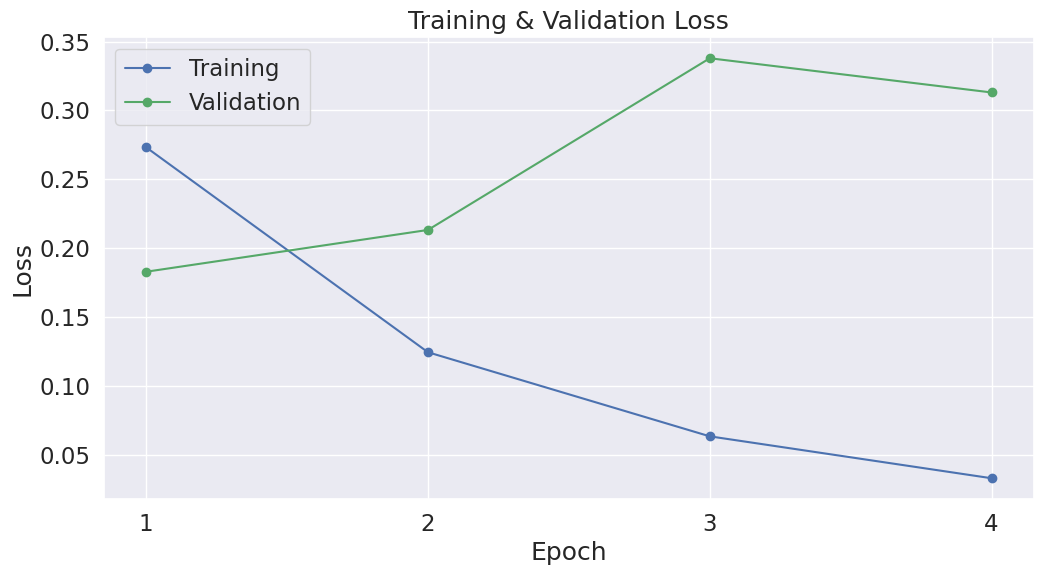

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# evaluate on test set

In [ ]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in test_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)

  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch

  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions.
      result = model(b_input_ids,
                     token_type_ids=None,
                     attention_mask=b_input_mask,
                     return_dict=True)

  logits = result.logits

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 28,619 test sentences...
    DONE.


Matthews Correlation Coefficient because classes are imbalanced

In [ ]:
print('Positive samples: %d of %d (%.2f%%)' % (dataframe.is_sarcastic.sum(), len(dataframe.is_sarcastic), (dataframe.is_sarcastic.sum() / len(dataframe.is_sarcastic) * 100.0)))

Positive samples: 13634 of 28619 (47.64%)


In [ ]:
from sklearn.metrics import matthews_corrcoef

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):

  # The predictions for this batch are a 2-column ndarray (one column for "0"
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()

  # Calculate and store the coef for this batch.
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


individual batch score


<ipython-input-31-a1af80ea924d>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)


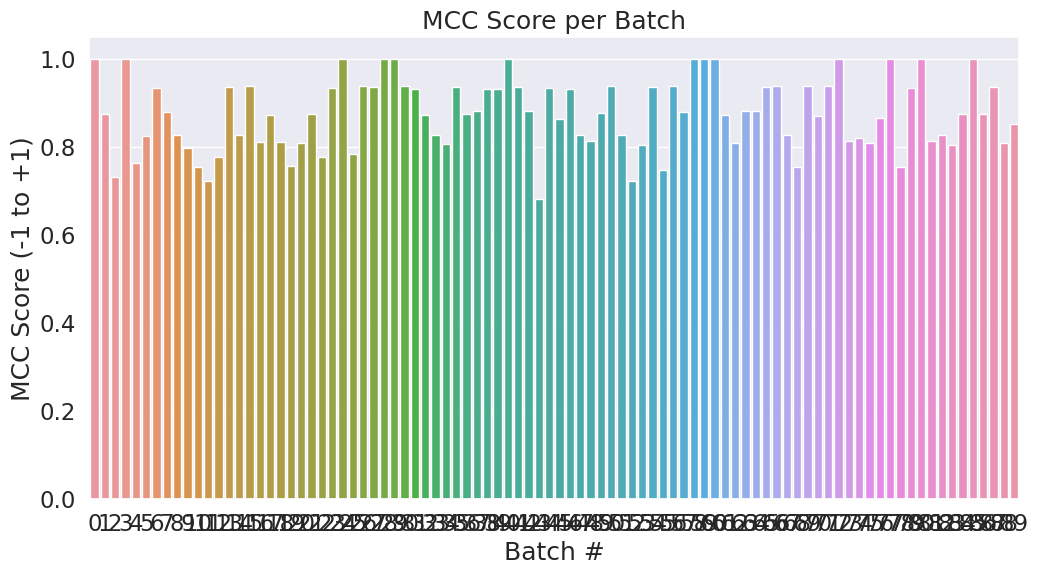

In [ ]:
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

# combine results for final MCC SCORE

In [ ]:
# Combine the results across all batches.
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.876
